# Part A: Airbnb Price Prediction and Insights

## Objective
The primary objective of this project is to develop a regression model that predicts the price of an Airbnb listing. Using features such as property type, room type, number of reviews,location, and amenities, the model will aim to estimate the price accurately.
## Overview 
This module implements a complete machine learning pipeline to predict Airbnb listing prices using **XGBoost**. The solution is designed to handle messy real-world data optimize model performance through hyperparameter tuning.

## Dataset Overview
1) id - Unique identifier for the listing
2) log_price -Log-transformed price of the listing
3) property_type -Type of property (e.g., Apartment, House)
4) room_type - Type of room offered (e.g., Entire home/apt, Private room)
5) amenities - List of amenities available at the property
6) accommodates - Number of guests the property can accommodate
7) bathrooms - Number of bathrooms in the listing
8) bed_type - Type of bed provided (e.g., Real Bed, Futon)
9) cancellation_policy - Cancellation policy of the host (e.g., Moderate, Strict)
10) cleaning_fee -Indicates if a cleaning fee is charged (TRUE/FALSE)
11) city - City where the property is located
12) description - Description of the property provided by the host
13) first_review - Date of the first review for the listing
14) host_has_profile_pic - Indicates if the host has a profile picture (t/f)
15) host_identity_verified - Indicates if the host's identity is verified (t/f)
16) host_response_rate - Host's response rate (e.g., 100%)
17) host_since - Date when the host joined Airbnb


In [1]:
import numpy as np
import pandas as pd
import re
from datetime import datetime, timezone
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

#### Essential Exploratory Data Analysis (EDA)

In [2]:
data = pd.read_excel("Airbnb_data.xlsx")
data.shape


(74111, 29)

In [3]:
data.describe()

,id,log_price,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,55812.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,0.943520,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,0.163418,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,1.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [4]:
data.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate        float64
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [5]:
data.isnull().sum()

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   6
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                         10
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     968
bedrooms                     91
beds                        131
dtype: int64

In [6]:
for column in data.columns:
    print(data[column].unique())

[ 6901257  6304928  7919400 ... 18688039 17045948  3534845]
[5.01063529 5.12989872 4.97673374 6.62007321 4.74493213 4.44265126
 4.41884061 4.78749174 3.58351894 4.60517019 4.24849524 5.29831737
 4.95582706 4.09434456 4.31748811 4.59511985 4.88280192 4.38202663
 3.68887945 4.90527478 4.00733319 6.95654544 5.00394631 4.55387689
 5.19295685 4.65396035 3.8286414  5.22035583 4.48863637 4.35670883
 4.82831374 3.912023   4.68213123 5.52146092 4.99721227 5.78382518
 3.55534806 4.15888308 4.75359019 4.77912349 4.94875989 5.85793315
 6.90775528 6.2146081  4.70048037 4.49980967 5.5174529  4.69134788
 3.80666249 5.16478597 5.24702407 4.57471098 4.8598124  5.08759633
 3.87120101 5.56068163 5.39362755 4.80402104 4.92725369 4.17438727
 6.1717006  6.55108033 5.29330482 4.06044301 5.6347896  6.10924758
 5.9375362  4.86753445 5.0689042  4.12713438 4.46590812 3.4657359
 4.96284463 5.59842196 3.49650756 3.40119738 5.6167711  4.93447393
 3.8918203  7.15070146 6.74523635 4.34380542 6.52795792 5.54126354
 5.

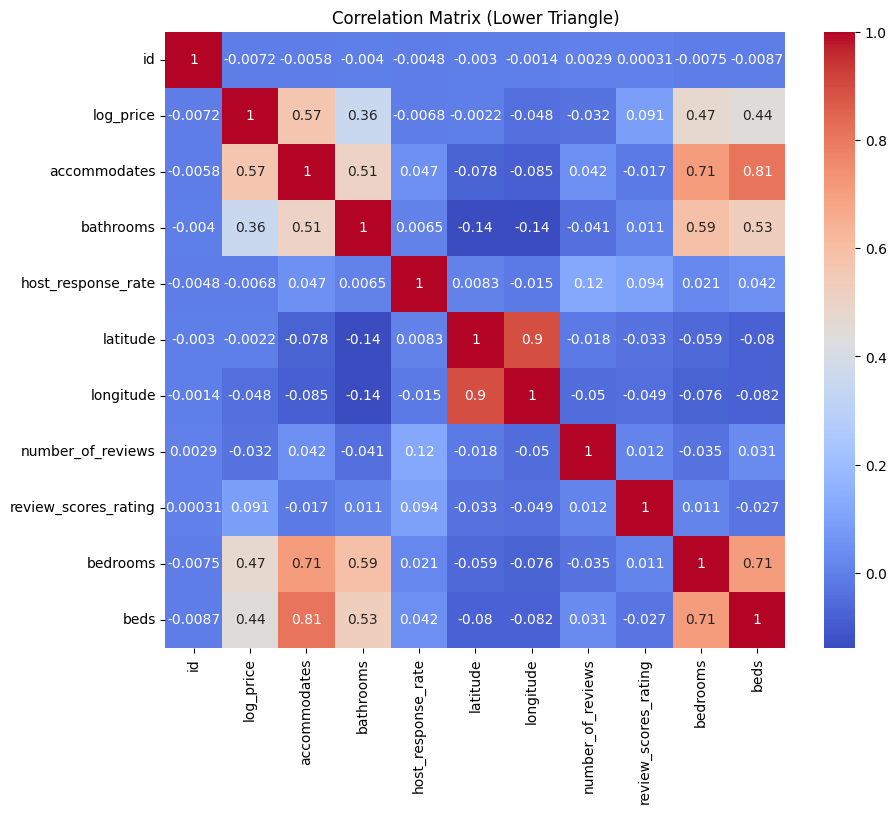

In [7]:
import numpy as np
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist() 
data = data[numeric_features] # Compute correlation matrix 
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Lower Triangle)')
plt.show()


## Load the data

In [8]:
def load_data(csv_path="airbnb_data.xlsx"): # Update this path to your actual filename (your previous code had a space) 
    df = pd.read_excel(csv_path) 
    return df

## Removing the unvalid zipcode

In [9]:
def is_valid_zip(z): 
    if pd.isna(z): 
        return False 
    z = str(z).strip() 
    return bool(re.match(r'^\d{5}(-\d{4})?$', z))

### Advanced Engineering: Amenities Parsing
The raw `amenities` column often contains strings in varying formats (e.g., `"{Wifi, TV}"`, `["Wifi", "TV"]`). The script handles this via:
1. **Normalization:** Removing brackets, braces, and quotes using `parse_amenities_text`.
2. **Categorization:** Mapping individual items to broader categories (e.g., "Pool" → **Luxury**, "Stove" → **Kitchen**) using the `amenity_flag` function.
3. **One-Hot Flags:** Creating binary columns (e.g., `amenity_kitchen`, `amenity_security`) indicating the presence of specific facility groups.

In [10]:
def parse_amenities_text(x):
    # Accepts strings like {"Wifi","TV"} or ["Wifi","TV"] or "Wifi,TV"
    if not isinstance(x, str) or not x.strip():
        return []
    s = x.replace("{", "").replace("}", "").replace("[", "").replace("]", "")
    s = s.replace('"', "").replace("'", "").strip()
    items = [t.strip() for t in s.split(",") if t.strip()]
    return items


## Data Cleaning & Feature Engineering
The `clean_and_engineer` function is the workhorse of this script. It transforms raw, unstructured data into model-ready numerical features.

### Key Cleaning Steps:
* **Boolean Standardization:** Converts confusing strings like `'t'`/`'f'` into binary integers (`1`/`0`) for columns like `host_identity_verified`.
* **String Sanitization:** Removes `%` signs from `host_response_rate` and converts it to integers.
* **Robust Date Handling:** The script attempts multiple date formats (`%d-%m-%Y`, `%Y-%m-%d`, etc.) to parse `host_since`, ensuring valid tenure calculations even with inconsistent input formats.
* **Zipcode Validation:** Uses Regex (`^\d{5}(-\d{4})?$`) to filter out invalid or malformed US zip codes.

In [11]:
def amenity_flag(items, group):
    if not items:
        return 0
    # Case-insensitive membership   
    items_lower = set(i.lower() for i in items)
    return int(any(g.lower() in items_lower for g in group))

In [12]:
def clean_and_engineer(df):
    # Drop known non-model columns (adjust as needed)
    drop_cols = ['description', 'first_review', 'name', 'thumbnail_url', 'id','bedrooms']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # Normalize boolean-like columns
    if 'host_has_profile_pic' in df.columns:
        df['host_has_profile_pic'] = (
            df['host_has_profile_pic'].astype(str).str.lower().str.strip()
        ).apply(lambda x: 't' if x == 't' else 'f')

    if 'host_identity_verified' in df.columns:
        df['host_identity_verified'] = (
            df['host_identity_verified'].astype(str).str.lower().str.strip()
        ).apply(lambda x: 't' if x == 't' else 'f').map({'t': 1, 'f': 0})

    # Host response rate: "85%" -> 85
    if 'host_response_rate' in df.columns:
        df['host_response_rate'] = df['host_response_rate'].fillna('0%')
        df['host_response_rate'] = (
            df['host_response_rate'].astype(str).str.replace('%', '', regex=False)
        )
        df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce').fillna(0).astype(int)

    # Host tenure in years
    if 'host_since' in df.columns:
        df = df.dropna(subset=['host_since'])
        df = df[df['host_since'].astype(str).str.strip() != '']
        # Try multiple date formats robustly
        def to_date(s):
            for fmt in ['%d-%m-%Y', '%Y-%m-%d', '%m/%d/%Y']:
                try:
                    return pd.to_datetime(s, format=fmt)
                except Exception:
                    continue
            return pd.to_datetime(s, errors='coerce')
        df['host_since'] = df['host_since'].apply(to_date)
        df = df.dropna(subset=['host_since'])
        today = pd.Timestamp(datetime.now(timezone.utc).date())
        df['host_tenure_years'] = ((today - df['host_since']).dt.days) / 365.0
        df = df.drop(columns=['host_since'])

    df = df.drop(columns=['last_review'], errors='ignore')

    cols_to_check = [
        'review_scores_rating',
        'zipcode',
        'bedrooms',
        'beds',
        'neighbourhood',
        'bathrooms'
    ]
    existing_checks = [c for c in cols_to_check if c in df.columns]
    if existing_checks:
        df = df.dropna(subset=existing_checks)

    # ZIP code validity filter (if column exists)
    if 'zipcode' in df.columns:
        df = df[df['zipcode'].apply(is_valid_zip)]
        # Keep zipcode as string (categorical)
        df['zipcode'] = df['zipcode'].astype(str)

    # Amenities engineering
    amenity_groups = {
        "Basic": ["Wireless Internet", "Heating", "Air conditioning", "Essentials", "Hot water", "Shampoo", "Hair dryer", "Hangers"],
        "Safety": ["Smoke detector", "Carbon monoxide detector", "Fire extinguisher", "First aid kit", "Safety card"],
        "Family": ["Crib", "High chair", "Pack ’n Play/travel crib", "Children’s books and toys", "Babysitter recommendations"],
        "Luxury": ["Pool", "Hot tub", "Gym", "Beachfront", "Indoor fireplace", "EV charger"],
        "Kitchen": ["Kitchen", "Microwave", "Oven", "Stove", "Dishwasher", "Coffee maker", "Refrigerator", "Cooking basics", "Dishes and silverware"],
        "Accessibility": ["Wheelchair accessible", "Step-free access", "Wide doorway", "Accessible-height toilet", "Accessible-height bed"],
        "Parking": ["Free parking on premises", "Free parking on street", "Paid parking off premises"],
        "Entertainment": ["TV", "Cable TV", "Internet", "Game console", "BBQ grill"]
    }

    if 'amenities' in df.columns:
        parsed = df['amenities'].apply(parse_amenities_text)
        for category, items in amenity_groups.items():
            df[f'amenity_{category.lower()}'] = parsed.apply(lambda x: amenity_flag(x, items))
        # Optional simple richness feature
        df['amenity_count'] = parsed.apply(lambda x: len(x))
        # Drop original raw column
        df = df.drop(columns=['amenities'])

    return df

In [13]:
def prepare_features(df, target_col=None):
    # If your target is the first column, use that. Otherwise, specify target_col.
    if target_col is None:
        target_col = df.columns[0]

    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    # Ensure target is numeric
    y = pd.to_numeric(y, errors='coerce')
    mask = y.notna()
    X, y = X.loc[mask], y.loc[mask] 

    return X, y

## Machine Learning Pipeline
To ensure reproducibility and prevent data leakage, the script uses a Scikit-Learn `Pipeline`.

### Preprocessing (`ColumnTransformer`)
* **Categorical Data:** Processed using `OneHotEncoder` with `handle_unknown='ignore'` to manage unseen categories during inference.
* **Numerical Data:** Passed through unchanged (Passthrough).

### Model Configuration (`XGBRegressor`)
The pipeline integrates an XGBoost Regressor with the following initial settings:
* **Objective:** `reg:squarederror` (standard for regression tasks).
* **Tree Method:** `hist` (optimized for speed on larger datasets).
* **Estimators:** 500 trees (tuned later).

In [14]:
def build_pipeline(X):
    # Separate numeric and categorical
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

    # OneHot for categoricals, passthrough numerics (no scaling needed for trees)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
        ]
    )

    model = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist",
        enable_categorical=True,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    )

    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipe

## 5. Hyperparameter Tuning
The script employs `RandomizedSearchCV` to find the optimal hyperparameters efficiently. It explores a defined grid over **25 iterations**:

| Parameter | Values Explored | Impact |
| :--- | :--- | :--- |
| `max_depth` | 4, 6, 8 | Controls model complexity/overfitting. |
| `learning_rate` | 0.03, 0.05, 0.1 | Step size shrinkage to prevent overfitting. |
| `subsample` | 0.7, 0.8, 0.9 | Fraction of samples used per tree. |
| `reg_alpha` / `lambda` | 0.0 - 1.0 | L1/L2 regularization terms. |

In [15]:
def tune_model(pipe, X_train, y_train):
    param_dist = {
        "model__max_depth": [4, 6, 8],
        "model__learning_rate": [0.03, 0.05, 0.1],
        "model__subsample": [0.7, 0.8, 0.9],
        "model__colsample_bytree": [0.7, 0.8, 0.9],
        "model__n_estimators": [300, 500, 800],
        "model__reg_alpha": [0.0, 0.1, 0.3],
        "model__reg_lambda": [0.5, 1.0]
    }

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=40,
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_, -search.best_score_

## 6. Training & Evaluation
The final training phase includes a critical optimization step: **Early Stopping**.
* The model monitors the validation set performance during training.
* If the metric does not improve for **30 rounds**, training stops automatically. This prevents overfitting and saves computational resources.

In [16]:
# 6) Final training with early stopping
# -----------------------------
def train_final_model(model, X_train, y_train, X_val, y_val):
    # Preprocess train and validation sets using the pipeline’s preprocessor
    X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
    X_val_transformed = model.named_steps['preprocessor'].transform(X_val)

    # Set early stopping on the inner XGBRegressor
    model.named_steps['model'].set_params(early_stopping_rounds=30)

    # Fit the inner model with eval_set
    model.named_steps['model'].fit(
        X_train_transformed, y_train,
        eval_set=[(X_val_transformed, y_val)],
        verbose=False
    )

    return model


In [17]:
def plot_feature_importance(model):
    # 1. Extract feature names
    feature_names = model.named_steps["preprocessor"].get_feature_names_out()
    
    # 2. Get the importance scores
    importances = model.named_steps["model"].feature_importances_
    
    # 3. Organize into a DataFrame
    feat_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    # 4. Plot the Top 10
    plt.figure(figsize=(10, 6))
    
    # FIXED: Added hue="Feature" and legend=False to remove the warning
    sns.barplot(
        data=feat_df.head(10), 
        x="Importance", 
        y="Feature", 
        hue="Feature", 
        palette="viridis", 
        legend=False
    )
    
    plt.title("Top 10 Drivers of price") 
    
    plt.xlabel("Relative Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

### Evaluation Metrics:
* **RMSE (Root Mean Squared Error):** Measures the average magnitude of the error.
* **MAE (Mean Absolute Error):** The average absolute difference between predicted and actual values.
* **$R^2$ Score:** Represents the proportion of variance in the dependent variable explained by the model.

In [18]:
# -----------------------------
# 7) Evaluation
# -----------------------------
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_test, y_pred))),
        "MAE": float(mean_absolute_error(y_test, y_pred)),
        "R2": float(r2_score(y_test, y_pred))
    }

In [19]:
def main():
    # 1) Load
    df = load_data("Airbnb_data.xlsx")  # update filename if needed

    # 2) Clean + engineer
    df = clean_and_engineer(df)
    print("After cleaning:", df.shape)

    # 3) Prepare features
    X, y = prepare_features(df)  # by default, first column is target. If not, pass target_col="log_price"

    # 4) Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 5) Build pipeline
    pipe = build_pipeline(X)

    # 6) Tune
    tuned_model, best_params, best_rmse = tune_model(pipe, X_train, y_train)
    print("Best params:", best_params)
    print(f"Best CV RMSE: {best_rmse:.4f}")

    # 7) Final train with early stopping
    final_model = train_final_model(tuned_model, X_train, y_train, X_test, y_test)

    plot_feature_importance(final_model)
    
    # 8) Evaluate
    metrics = evaluate(final_model, X_test, y_test)
    print("Test metrics:", metrics)


After cleaning: (48813, 30)
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'model__subsample': 0.7, 'model__reg_lambda': 0.5, 'model__reg_alpha': 0.1, 'model__n_estimators': 800, 'model__max_depth': 8, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.9}
Best CV RMSE: 0.3291


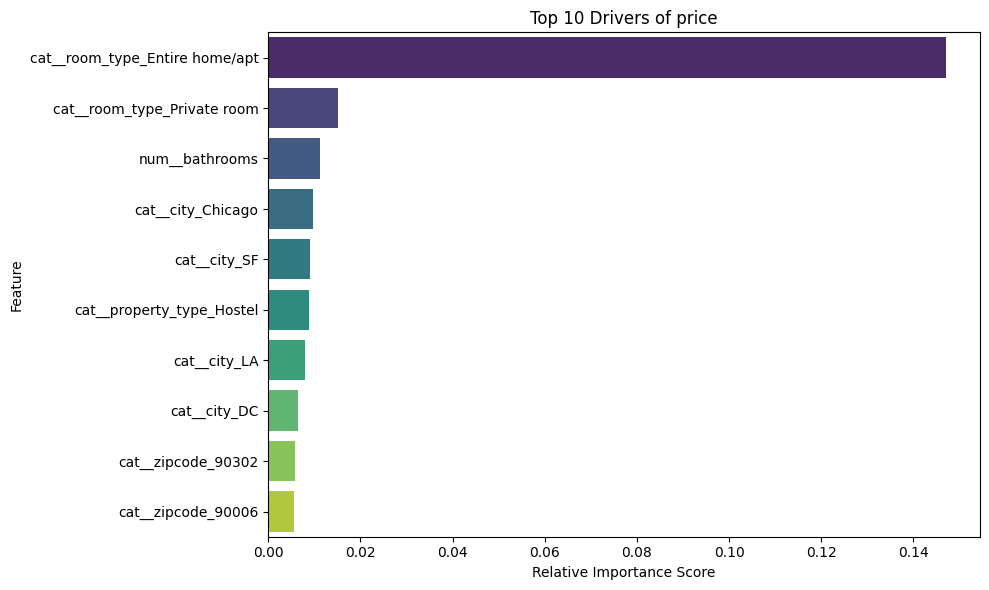

Test metrics: {'RMSE': 0.32806187352100974, 'MAE': 0.24391156330825253, 'R2': 0.758806458155076}


In [20]:
if __name__ == "__main__":
    main()

# Conclusion
model performed very well. It achieved a **score of 76%** ($R^2$), which means it correctly identifies three-quarters of the reasons why Airbnb prices vary.

In practical terms, our price estimates are typically **within ($e^{0.243}$≈1.276) 27.6% of the actual listing price**. For a complicated market like Airbnb, where prices depend on personal taste and style, this is a strong result.

I tested the model on new data that it had never seen before, and it performed just as well as it did during practice. This proves the model **did not just memorize the answers**—it actually learned the rules of how to price a home.

## What drives the price up?
According to the model, these are the top three factors that determine price:
1. **Privacy:** The #1 factor is whether the guest gets the **"Entire home/apt"**. Renting a whole apartment costs much more than a private room.
2. **Size:** The number of **bathrooms** and **bedrooms** is the second most important driver.
3. **Location:** Being in a major hub like **San Francisco** or **DC** significantly boosts the price compared to other cities.

## How i tuned it
I found that the model works best when it takes a **"slow and steady"** approach.
Instead of making fast, aggressive guesses, we configured the model to build **800 decision trees** very slowly (low learning rate). This prevented it from making mistakes caused by weird or extreme data points.

video link: - https://drive.google.com/file/d/1nKw9wHWdGrzhI-SEYNFJwZkujDMHslq2/view?usp=sharing